#Question 1

first of all, we install the yfinance library and import some libraries.

In [1]:
!pip install yfinance -q

     |████████████████████████████████| 6.4 MB 17.4 MB/s 


In [2]:
import yfinance as yf
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot as plt

now we download the train and test dataset just like the given link.

In [45]:
train_data = yf.download("BTC-USD", start="2014-01-01", end="2021-09-01")
test_data = yf.download("BTC-USD", start="2021-09-02", end="2021-12-25")
train_data.head(10)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100
2014-09-22,399.100006,406.915985,397.130005,402.152008,402.152008,24127600
2014-09-23,402.092010,441.557007,396.196991,435.790985,435.790985,45099500
2014-09-24,435.751007,436.112000,421.131989,423.204987,423.204987,30627700
2014-09-25,423.156006,423.519989,409.467987,411.574005,411.574005,26814400


here you can visualize both sets.

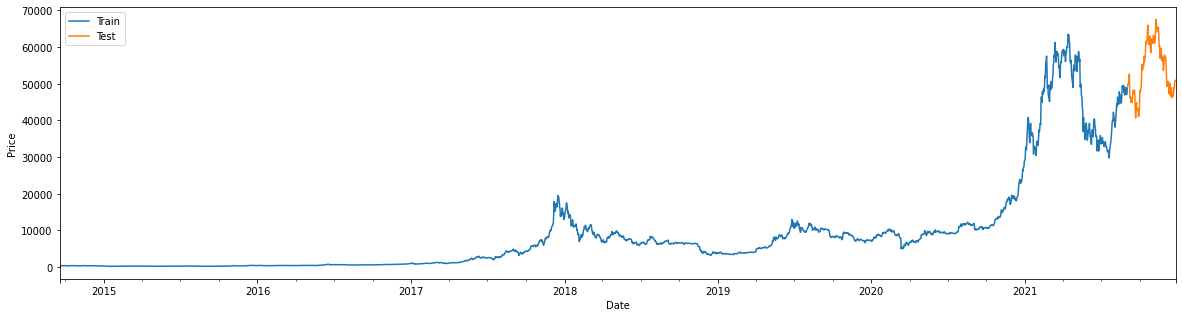

In [4]:
plt.figure(figsize=(20,5))
train_data.Close.plot()
test_data.Close.plot()
plt.ylabel('Price')
plt.legend (["Train", "Test"])
plt.show()

then we have to convert these dataframes to numpy array so we can work with them easily. here we only want to use the column "Close" for train and test.

you can see the shapes after this conversion.

In [46]:
train_set = train_data.Close.values.reshape(-1, 1)
test_set = test_data.Close.values.reshape(-1, 1)

print("train:", train_set.shape, "    test:", test_set.shape)

train: (2542, 1)     test: (115, 1)


we need to normalize our data for better results. we do this here using MinMaxScaler method implemented in sklearn library. 

In [47]:
scaler = MinMaxScaler()
scaler.fit(train_set)

train_normalized = scaler.fit_transform(train_set)
test_normalized = scaler.fit_transform(test_set)

np.min(train_normalized), np.max(train_normalized)

(0.0, 1.0)

some hyperparameters that given by the question.

In [48]:
BATCH_SIZE = 32
EPOCHS = 100
OPTIMIZER = 'adam'
LOSS = 'mean_squared_error'
PAST_VALUES = 60

this is an important part of preprocessing. we choose the PAST_VALUES last items before each item for train, and the value of that item as its label. so the shapes changes as you see.

we don't put label for the first PAST_VALUES items. because we don't have the 60 days before them and this cand disturb our model's learning.

In [49]:
n_train = train_normalized.shape[0]
x_train = np.zeros((n_train-PAST_VALUES, PAST_VALUES, 1))
y_train = np.zeros((n_train-PAST_VALUES,))
for i in range(PAST_VALUES, n_train):
  temp = 0
  for j in range(i-PAST_VALUES, i):
    x_train[i-PAST_VALUES,temp,0] = train_normalized[j,0]
    temp+=1
  y_train[i-PAST_VALUES] = train_normalized[i,0]

print("x_train:", x_train.shape)
print("y_train:", y_train.shape)

x_train: (2482, 60, 1)
y_train: (2482,)


and the same thing for test. we assume the last PAST_VALUE items of training_normalized before the test set.

In [50]:
n_test = test_normalized.shape[0]
test_normalized_temp = np.concatenate((train_normalized[n_train-PAST_VALUES:], test_normalized))
x_test = np.zeros((n_test, PAST_VALUES, 1))
y_test = np.zeros((n_test,))
for i in range(n_test):
  temp = 0
  for j in range(i, i+PAST_VALUES):
    x_test[i,temp,0] = test_normalized_temp[j,0]
    temp+=1
  y_test[i] = test_normalized_temp[i+PAST_VALUES,0]

print("x_test:", x_test.shape)
print("y_test:", y_test.shape)

x_test: (115, 60, 1)
y_test: (115,)


now we can define the RNN model with LSTM layers like the question. then compile and fit it to train set.

In [14]:
model = tf.keras.models.Sequential([
                                    tf.keras.layers.Input((PAST_VALUES,1)),
                                    tf.keras.layers.LSTM(units=50, return_sequences=True),
                                    tf.keras.layers.Dropout(0.2),
                                    tf.keras.layers.LSTM(units=50, return_sequences=True),
                                    tf.keras.layers.Dropout(0.2),
                                    tf.keras.layers.LSTM(units=50, return_sequences=True),
                                    tf.keras.layers.Dropout(0.2),
                                    tf.keras.layers.LSTM(units=50, return_sequences=False),
                                    tf.keras.layers.Dense(units=1)
])
model.compile(OPTIMIZER, LOSS)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 50)            10400     
                                                                 
 dropout (Dropout)           (None, 60, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 60, 50)            20200     
                                                                 
 dropout_1 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_2 (LSTM)               (None, 60, 50)            20200     
                                                                 
 dropout_2 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_3 (LSTM)               (None, 50)                2

accuracy is not a good metric here so we don't visualize it. because the model surely cannot predict the exact value of price and accuracy just shows the percentage of exact predicts. 

the mean square loss could be a good metric to estimate how good the model is. because you can see it decreases at each epoch and at the end of training it is near e-04, so the model works well enough.

In [15]:
model.fit(x_train, y_train, BATCH_SIZE, EPOCHS)

Epoch 1/100
78/78 [==============================] - 15s 62ms/step - loss: 0.0056
Epoch 2/100
78/78 [==============================] - 5s 62ms/step - loss: 0.0016
Epoch 3/100
78/78 [==============================] - 5s 64ms/step - loss: 0.0015
Epoch 4/100
78/78 [==============================] - 5s 64ms/step - loss: 0.0012
Epoch 5/100
78/78 [==============================] - 5s 62ms/step - loss: 0.0012
Epoch 6/100
78/78 [==============================] - 5s 62ms/step - loss: 0.0011
Epoch 7/100
78/78 [==============================] - 5s 62ms/step - loss: 0.0015
Epoch 8/100
78/78 [==============================] - 5s 61ms/step - loss: 9.7709e-04
Epoch 9/100
78/78 [==============================] - 5s 61ms/step - loss: 9.0865e-04
Epoch 10/100
78/78 [==============================] - 5s 62ms/step - loss: 7.7484e-04
Epoch 11/100
78/78 [==============================] - 5s 65ms/step - loss: 7.8957e-04
Epoch 12/100
78/78 [==============================] - 5s 70ms/step - loss: 7.2675e-04
Epoc

finally, we can predict the test set with the model and compare the result with the real value of price on that days. 

surely, we should bring the values back to the real numbers and not the normalized ones. we can do that with inverse_transform method of scaler that we defined before.

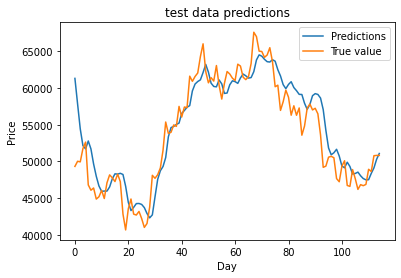

In [51]:
predictions_test = np.squeeze(scaler.inverse_transform(model.predict(x_test)))
y_test_inversed = np.squeeze(scaler.inverse_transform([y_test]))
plt.plot(predictions_test)
plt.plot(y_test_inversed)
plt.title('test data predictions')
plt.xlabel('Day')
plt.ylabel('Price')
plt.legend (["Predictions", "True value"])
plt.show()

here we predict next 3 months, means 90 days. like before, we put the last PAST_VALUES items of test set before these array.

and put the predict of model for each day in the array, rhe use it on the next day.

In [ ]:
n_future = 90
future_normalized = np.concatenate((test_normalized[n_test-PAST_VALUES:], np.zeros((n_future, 1))))
print(future_normalized)
for i in range(PAST_VALUES, n_future+PAST_VALUES):
  counter=0
  temp = future_normalized[i-PAST_VALUES:i].T
  temp = np.expand_dims(temp, axis=2)
  prediction = model.predict(temp)
  future_normalized[i] = np.squeeze(prediction)
future_normalized = future_normalized[PAST_VALUES:]

finally we can plot the prediction results for next 3 months. x axis "day" = 0 means today, x=1 means tomorrow and ... so buy bitcoin :)

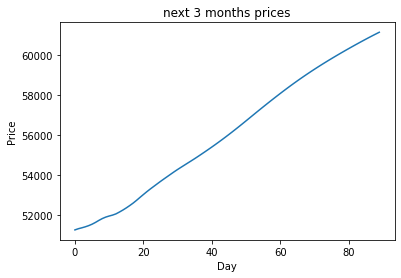

In [53]:
future_prices = scaler.inverse_transform(future_normalized)
plt.plot(future_prices)
plt.title('next 3 months prices')
plt.xlabel('Day')
plt.ylabel('Price')
plt.show()

#Question 2

import requirements:

In [ ]:
from tensorflow.keras.layers import GRU, Dense, RepeatVector
from tensorflow.keras.models import Sequential, load_model
import numpy as np
import os
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


load dataset:

In [ ]:
!wget -q -N 'https://raw.githubusercontent.com/armanheydari/my-datas/master/enc-dec.txt'
text = open('enc-dec.txt').read().split('\n')

parameters and hyperparameters:

In [ ]:
symbols = 'abcdefghijklmnopqrstuvwxyz '
samples_no = len(text)
words_length = 10
alphabeticals = len(symbols)
optimizer = 'adam'
loss = 'categorical_crossentropy'
epochs = 10
batch_size=32
save_path = '/content/gdrive/MyDrive/DL_HW12/my_model.h5'

pre processing data and create train set:

In [ ]:
x_train = np.zeros((samples_no, words_length, alphabeticals))
y_train = np.zeros((samples_no, words_length, alphabeticals))
for i in range(samples_no):
  [d, l] = text[i].split('\t')
  if len(d) < words_length:
    d+=(words_length-len(d))*' '
  if len(l) < words_length:
    l+=(words_length-len(l))*' '
  for j in range(words_length):
    x_train[i, j, symbols.find(d[j])] = 1
    y_train[i, j, symbols.find(l[j])] = 1

print("train:", x_train.shape)
print("labels:", y_train.shape)

train: (152273, 10, 27)
labels: (152273, 10, 27)


create the test set from the given sentence:

In [ ]:
encrypted = "onmltsrqpoihgrezcba lknrvjihgfueiizltflk"
chunks = [encrypted[i:i+words_length] for i in range(0, len(encrypted), words_length)]
x_test = np.zeros((len(chunks), words_length, alphabeticals))
for i in range(len(chunks)):
  for j in range(words_length):
    x_test[i, j, symbols.find(chunks[i][j])] = 1

print("test:", x_test.shape)

test: (4, 10, 27)


here, we define the train model which creates the GRU model and fit it on the dataset. if the bollean parameter 'is_load_model' sets to True, means we want to load the saved model and continue to train the model. but if it's False, means we want to create a new model with the layers that we pass to this method.

In [ ]:
def train_model(layers=None, is_load_model=True):
  if is_load_model:
    model = load_model(save_path)
  else:
    model = Sequential(layers)
  model.compile(optimizer, loss, metrics=['accuracy'])
  model.summary()
  for i in range(epochs):
    model.fit(x_train, y_train, batch_size, 1)
    model.save(save_path)

we can use this method to see the model's result on the test set:

In [ ]:
def test_model(model):
  prediction = model.predict(x_test)
  result = ""
  for i in range(prediction.shape[0]):
    for j in range(prediction.shape[1]):
      result += symbols[np.argmax(prediction[i, j])]
  print(result)

on the next cells, we train and test some GRU models to see which of them works better.

In [ ]:
train_model([
              GRU(units=128, input_shape=(words_length, alphabeticals)),
              RepeatVector(words_length),
              GRU(units=128, return_sequences=True),
              Dense(units=alphabeticals, activation='softmax')]
              , is_load_model=False)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 128)               60288     
                                                                 
 repeat_vector (RepeatVector  (None, 10, 128)          0         
 )                                                               
                                                                 
 gru_1 (GRU)                 (None, 10, 128)           99072     
                                                                 
 dense (Dense)               (None, 10, 27)            3483      
                                                                 
Total params: 162,843
Trainable params: 162,843
Non-trainable params: 0
_________________________________________________________________
4759/4759 [==============================] - 53s 11ms/step - loss: 0.1416 - accuracy: 0.9573


In [ ]:
test_model(load_model(save_path))

    k        love     deep    slearring 


In [ ]:
train_model([
              GRU(units=256, input_shape=(words_length, alphabeticals)),
              RepeatVector(words_length),
              GRU(units=256, return_sequences=True),
              Dense(units=alphabeticals, activation='softmax')]
              , is_load_model=False)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_2 (GRU)                 (None, 256)               218880    
                                                                 
 repeat_vector_1 (RepeatVect  (None, 10, 256)          0         
 or)                                                             
                                                                 
 gru_3 (GRU)                 (None, 10, 256)           394752    
                                                                 
 dense_1 (Dense)             (None, 10, 27)            6939      
                                                                 
Total params: 620,571
Trainable params: 620,571
Non-trainable params: 0
_________________________________________________________________
4759/4759 [==============================] - 63s 13ms/step - loss: 0.1112 - accuracy: 0.9653


In [ ]:
test_model(load_model(save_path))

   bi        love   redeep    alearning 


In [ ]:
train_model([
              GRU(units=128, input_shape=(words_length, alphabeticals)),
              RepeatVector(words_length),
              GRU(units=128, return_sequences=True),
              GRU(units=128, return_sequences=True),
              Dense(units=alphabeticals, activation='softmax')]
              , is_load_model=False)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_7 (GRU)                 (None, 128)               60288     
                                                                 
 repeat_vector_3 (RepeatVect  (None, 10, 128)          0         
 or)                                                             
                                                                 
 gru_8 (GRU)                 (None, 10, 128)           99072     
                                                                 
 gru_9 (GRU)                 (None, 10, 128)           99072     
                                                                 
 dense_3 (Dense)             (None, 10, 27)            3483      
                                                                 
Total params: 261,915
Trainable params: 261,915
Non-trainable params: 0
________________________________________________

In [ ]:
test_model(load_model(save_path))

    i        love     deep    alearning 


In [ ]:
train_model([
              GRU(units=64, input_shape=(words_length, alphabeticals)),
              RepeatVector(words_length),
              GRU(units=64, return_sequences=True),
              GRU(units=64, return_sequences=True),
              Dense(units=alphabeticals, activation='softmax')]
              , is_load_model=False)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_10 (GRU)                (None, 64)                17856     
                                                                 
 repeat_vector_4 (RepeatVect  (None, 10, 64)           0         
 or)                                                             
                                                                 
 gru_11 (GRU)                (None, 10, 64)            24960     
                                                                 
 gru_12 (GRU)                (None, 10, 64)            24960     
                                                                 
 dense_4 (Dense)             (None, 10, 27)            1755      
                                                                 
Total params: 69,531
Trainable params: 69,531
Non-trainable params: 0
__________________________________________________

In [ ]:
test_model(load_model(save_path))

s  wa        lave   swdeer    plearning 
